In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits

from skimage.filters import threshold_otsu
from scipy.ndimage import shift
from scipy.optimize import curve_fit

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# ----------------------------- Help -------------------------------------

'''
# ---------------------------------------- Переменные -----------------------------------------------------------------
nx - ширина окна для автокорреляции зрачка, должно быть минимум в 2 раза больше, чем ширина зрачка [pix]
I0c - индикатор для зрачка  
f_scale - шаг по частоте, [м^-1]
delta - шаг апертуры или же просто размер 1ого пикселя, [м] 

def frequency_dim - создание пространства частот 
def c_jk - создание коэффициента передачи зрачка
def move_gamma - сдвиг гаммы относительно центра взависимости от скорости ветра
# ---------------------------------------------------------------------------------------------------------------------

Ex:

Для примера пусть Cn2 соответствует качеству изображения, равному 1 угловой секунде (типичное качество изображения) на длине 
волны 500 нм. Для удобства величину Cn2(z)dz рассматриваем как одну величину, обозначим ее C. Тогда:
    beta = 0.98 * lambda/r0 = 1, следовательно: r0 = 0.98*lambda*206265,
Пусть мы наблюдаем в зените, тогда параметр Фрида будет:
    r0 = (0.423*k^2 * C)^(-3/5), где k = 2*pi/lambda.
Далее можно просто выразить и посчитать С
    Cn2_ex = pow((0.98*lambda_)*206265, -5/3) / (0.423*pow(2*np.pi/lambda_, 2))
    
А вообще, нам неважно какое значение Cn2 брать, ответ всегда будет верным
# ---------------------------------------------------------------------------------------------------------------------

Подложки на изображении-результате кросс-корреляции быть не должно (ее видно если брать модуль от мнимой части). Видно, 
что значения мнимой части очень маленькие, поэтому можно выводить сразу действительную часть.
Черные области рядом с пиками - зоны Френеля. По радиусу этих зон можно посчитать дистанцию распространения
'''
print()

In [3]:
# ------------------------ Апертурный фильтр ----------------------
def aperture_func(fx, fy, delta): 
    res = np.abs(np.sinc(delta*fx)*np.sinc(delta*fy))**2
    res[np.isnan(res)] = 0
    return res
    
# ------------------------ Модуль |f|^11/3 -------------------------
def abs_f(fx, fy):
    res = pow(np.sqrt(fx**2+fy**2), -11./3.)
    res[np.isnan(res)] = 0
    return res

# ----------------------- Фильтр Френеля --------------------------------
def ffilter(z, lambda_): 
    global fx, fy
    res = pow(np.sin(np.pi*z*lambda_*(fx**2+fy**2)), 2) / pow(lambda_, 2)
    res[np.isnan(res)] = 0
    return res

# ------------------------- Коэффициент передачи зрачка ------------------
def c_jk():
    global frame
    nx = 2 * frame.shape[0] + 1
    I0c = (frame != 0) * int(1)
    I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    res /= np.max(res)
    return res, nx

# --------------------------- Спектральный фильтр -------------------------------------
def sfilter(z=None):
    global D, frame, lambda_max, f_lambda, nx
    coeff = 100
    k = 1000*coeff
    lambda_max_new = int(lambda_max*coeff)
    lambdas = np.linspace(0, lambda_max_new, k) * pow(10, -9) # [м]

    tail = np.zeros((len(lambdas) - len(f_lambda)))
    f_lambda_new = np.append(f_lambda, tail)
    res_fft = pow((np.imag(np.fft.fft(f_lambda_new/lambdas))), 2)

    delta_lambdas = (lambda_max_new / len(lambdas)) * pow(10, -9) # период дискретизации, шаг по частоте [м]
    omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]

    delta = D/frame.shape[0] # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
    f_scale = 1/(delta*nx) # шаг по частоте, [м^-1]

    xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
    xx_scale = f_scale * xx 
    yy_scale = f_scale * yy
    f_abs = np.sqrt(pow(xx_scale, 2) + pow(yy_scale, 2))

    omega = 0.5 * z * pow(f_abs, 2) # аргумент, шаг по частоте, [м^-1]
    omega = np.ravel(omega)
    omega_new = np.interp(omega, np.linspace(0, omega_lambdas_scale, k), res_fft)
    omega_new = np.resize(omega_new, (nx, nx))
    
    return omega_new

# ----------------------------- Монохроматическая гамма -----------------------------------
def gamma_mono(X, Y, Vx, Vy, Cn2, z, lambda_):
    global cjk, f_scale, nx, f_11_3, A_f, sec_per_frame, latency
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 

    t = sec_per_frame * latency
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta

    Fresnel_filter = ffilter(z, lambda_)
    
    res = f_11_3 * Fresnel_filter * A_f
    res[np.isnan(res)] = 0
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    res = Cn2 * const * res * pow(f_scale, 2) * nx * nx
    res = shift(res, (-Ypix, Xpix), order=5)
    res = res * cjk
    return res

# ----------------------------- Полихроматическая гамма -----------------------------------
def gamma_poly(X, Y, Vx, Vy, Cn2, z):
    global cjk, f_scale, nx, f_11_3, A_f, sec_per_frame, latency
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 

    t = sec_per_frame * latency
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
     
    Spectral_filter = sfilter(z=z)    
    
    res = f_11_3 * Spectral_filter * A_f
    res[np.isnan(res)] = 0
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    res = Cn2 * const * res * pow(f_scale, 2) * nx * nx    
    res = shift(res, (-Ypix, Xpix), order=5)
    res = res * cjk
    return res
 
# ----------------------------- Корреляция -----------------------------------
def correlate(frames, latency): 
    correlation = np.zeros_like(frames)
    def correlate_fft(img1, img2):
        corr = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(img1)*np.fft.fft2(img2).conjugate()))) # np.real; np.abs
        corr /= np.max(corr)
        return corr
    
    for i in range(frames.shape[0] - latency):
        correlation[i] = correlate_fft(frames[i], frames[i + latency])
    
    return np.mean(correlation, axis=0)
    
# ------------- Получение квадратного изображения зрачка и кросс-корреляции -----------------------
def pupil(images, latency): 
    image_average = np.mean(images, axis=0) # средний кадр серии
    image_binary = (image_average > threshold_otsu(image_average)) * int(255) # маска среднего кадра
    def flux_normalize(images): # нормировка потока, <I> = 0
        return (images)/(image_average) - 1

    def pupil_mask(images): # вырез зрачка
        return flux_normalize(images) * image_binary

    def pupil_square_cropp(images): # обрезка зрачка в квадрат
        mask = pupil_mask(images)[np.random.randint(images.shape[0])] != 0
        rows = np.flatnonzero((mask.any(axis=1))) 
        cols = np.flatnonzero((mask.any(axis=0)))
        return pupil_mask(images)[:, rows.min():rows.max()+1, cols.min():cols.max()+1] 
    
    def pupil_size_flatten(image): # подгонка размера изображения под квадратное
        if image.shape[0] >= image.shape[1]:
            image = np.pad(image, ((image.shape[0] - image.shape[1], 0), (0, 0)), 'constant', constant_values=(0))
        if image.shape[0] < image.shape[1]:
            image = np.pad(image, ((image.shape[1] - image.shape[0], 0), (0,0)), 'constant', constant_values=(0))
        return image
    
    res = pupil_square_cropp(images)   
    image = pupil_size_flatten(res[np.random.randint(res.shape[0])])
    
    cross_corr = correlate(res, latency)
    cross_corr = pupil_size_flatten(cross_corr)

    return image, cross_corr  

# ------------------------------- Main -------------------------------
def pupil_cc(file, file_bias=None, pupil_diameter=None, corr_latency=None, method=None):
    global frame, D, latency, sec_per_frame 
    D=pupil_diameter
    latency=corr_latency
    
    st = time.perf_counter() #
    if method == 'repeat':
        frame = np.loadtxt('C:/astro/data.gz')
        data_corr = np.loadtxt('C:/astro/data_corr.gz')
        with fits.open(file) as f:
            sec_per_frame = 1 / f[0].header['FRATE']
        
    
    if method == 'new':
        with fits.open(file_bias) as f:
            f.info()
            bias = np.mean(f[0].data, axis=0, dtype=np.float32)
    
        with fits.open(file) as f:
            f.info()
            sec_per_frame = 1 / f[0].header['FRATE']
            frame, data_corr = pupil(np.float32(f[0].data) - bias, latency)
  
    print('\nPupil shape:', frame.shape, 'corr shape:', data_corr.shape)
    print('time:', time.perf_counter()-st)

    v = (D / frame.shape[0]) / (latency * sec_per_frame)
    x = np.round(v*np.linspace(-data_corr.shape[0]//2+1, data_corr.shape[0]//2, 5), 2)
    y = np.round(v*np.linspace(-data_corr.shape[0]//2+1, data_corr.shape[0]//2, 5), 2)
    y = np.flipud(y)
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    fig.colorbar(ax.imshow(frame), ax = ax)
    ax.set_title('Pupil image')
    ax.grid(False)

    fig.colorbar(ax2.imshow(data_corr), ax = ax2)
    ax2.set_title(f'Cross-correlation, latency = {latency}')
    ax2.set_xticks(np.linspace(0, data_corr.shape[1], 5))
    ax2.set_yticks(np.linspace(0, data_corr.shape[0], 5))
    ax2.set_xticklabels(x, fontsize=12)
    ax2.set_yticklabels(y, fontsize=12)
    ax2.set_ylabel('Vy, m/s', fontsize=12)
    ax2.set_xlabel('Vx, m/s', fontsize=12)
    
    np.savetxt('C:/astro/data_corr.gz', data_corr)
    np.savetxt('C:/astro/data.gz', frame)
    return data_corr


Pupil shape: (227, 227) corr shape: (227, 227)
time: 0.08979099999999995


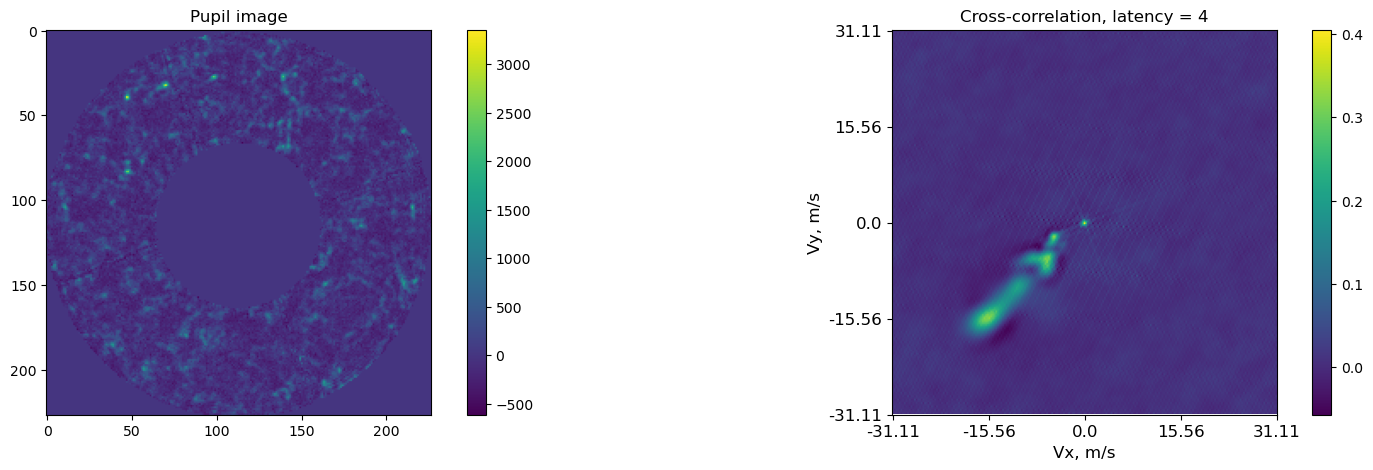

In [4]:
# ----------------------------- Inputs -----------------------------------
file = '20210130l_m2km.fits'      # файл с объектом
file_bias = 'bias20210130.fits'   # файл с кадром смещения, bias
corr_latency = 4                  # задержка в кросс-корреляции, [кол-во кадров]
pupil_diameter = 2.5              # диаметр телескопа, [м]

data_corr = pupil_cc(file, file_bias=file_bias, pupil_diameter=pupil_diameter, corr_latency=corr_latency, method='repeat')

In [5]:
# ------------------------- Глобальные переменные -------------------------
cjk, nx = c_jk() # c_jk, nx - размер окна автокорреляции

f_scale = frame.shape[0]/(D*nx) # шаг по частоте
delta = D/frame.shape[0] # шаг по пикселю/субапертуре или же просто размер одного пикселя

fx = f_scale * np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))[0]
fy = f_scale * np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))[1]

f_11_3 = abs_f(fx, fy) # |f|^11/3
A_f = aperture_func(fx, fy, delta) # A(f)

z = 2000 # дистанция распространения, [м]

resp_f = np.loadtxt('C:/astro/resp_f.gz') # Функция отклика
lambda_max = resp_f[0][-1] # Максимальное значение по длине волны
f_lambda = resp_f[1] # Значения функции отклика

a = int(2*frame.shape[0]+2 - frame.shape[0])//2
b = int(2*frame.shape[1]+2 - frame.shape[1])//2
data = np.pad(data_corr, ((a, a), (b, b)), 'constant', constant_values=(0))
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y) # Сетка для функций Гамм (будет нужна позже)

Dome turbulence, polychromatic scintillation
Cn2 value: 2.887430620123135e-12


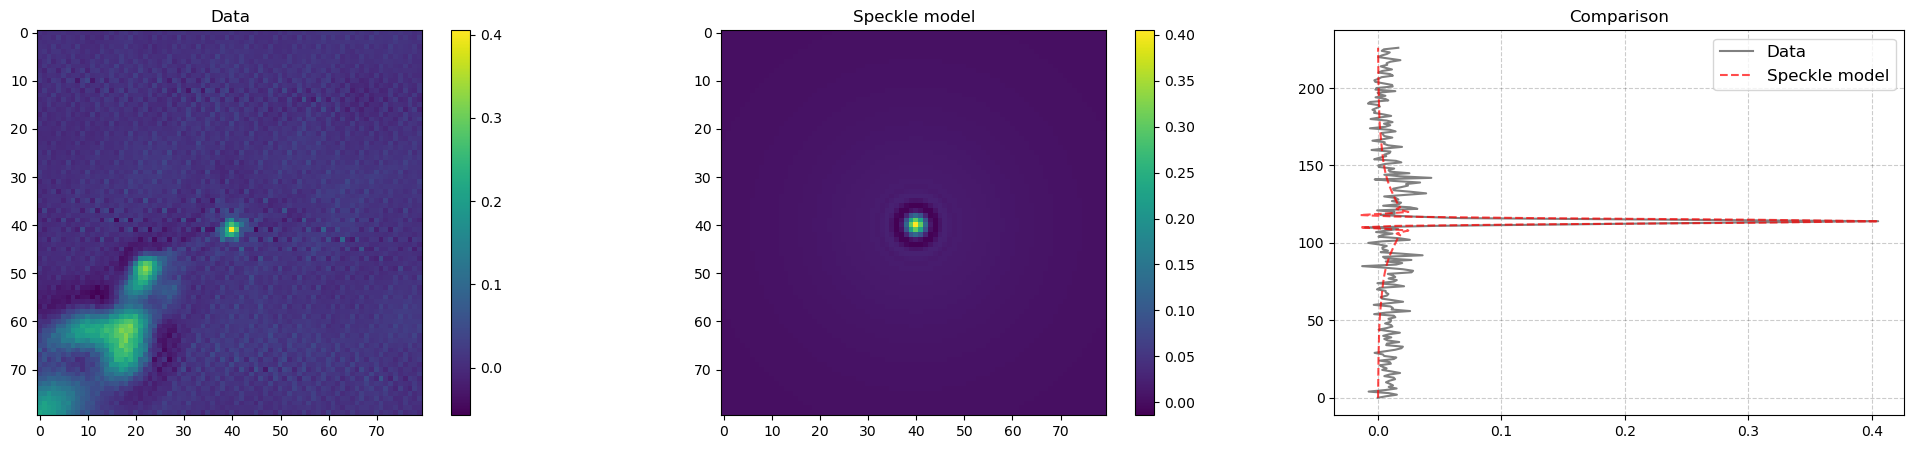

In [6]:
'''
Отрисовка подкупольной турбулентности
'''

def dome_turbulence(window_zoom=None, data_corr=None, type_='mono', lambda_=None):
    global X, Y
    Cn2_ex = 1*pow(10, -13)
    Vx = 0
    Vy = 0
    if type_ == 'mono':
        input_lambda = lambda_
        k = np.max(data_corr[data_corr.shape[0]//2-window_zoom:data_corr.shape[0]//2+window_zoom, 
                   data_corr.shape[1]//2-window_zoom:data_corr.shape[1]//2+window_zoom]) \
        / np.max((gamma_mono(X, Y, Vx, Vy, Cn2_ex, z, input_lambda)))

        Cn2 = Cn2_ex * k 
        gamma_new = gamma_mono(X, Y, Vx, Vy, Cn2, z, input_lambda)
        tit = 'Dome turbulence, monochromatic scintillation'
        print(tit)
        
    if type_ == 'poly':
        k = np.max(data_corr[data_corr.shape[0]//2-window_zoom:data_corr.shape[0]//2+window_zoom, 
                     data_corr.shape[1]//2-window_zoom:data_corr.shape[1]//2+window_zoom]) \
        / np.max((gamma_poly(X, Y,Vx, Vy, Cn2_ex, z)))

        Cn2 = Cn2_ex * k 
        gamma_new = gamma_poly(X, Y, Vx, Vy, Cn2, z) 
        tit = 'Dome turbulence, polychromatic scintillation'
        print(tit)
        

    centr = np.unravel_index(np.argmax(gamma_new), gamma_new.shape)

    X = data_corr[:, data_corr.shape[1]//2]
    Y = range(data_corr.shape[0])
    X3 = gamma_new[centr[0]-data_corr.shape[0]//2-1:centr[0]+data_corr.shape[0]//2, gamma_new.shape[1]//2]
    Y3 = range(data_corr.shape[0])

    fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

    fig.colorbar(ax.imshow(data_corr[data_corr.shape[0]//2-window_zoom:data_corr.shape[0]//2+window_zoom, 
                                 data_corr.shape[1]//2-window_zoom:data_corr.shape[1]//2+window_zoom]), ax = ax)
    ax.grid(False)

    fig.colorbar(ax2.imshow(gamma_new[centr[0]-window_zoom:centr[0]+window_zoom, 
                                      centr[1]-window_zoom:centr[1]+window_zoom]), ax=ax2)
    ax2.grid(False)

    ax3.plot(X, Y, alpha = 1, label = 'original corr', color = 'gray')
    ax3.plot(X3, Y3, alpha = 0.7, ls = '--', label = 'corected gamma', color = 'red')
#     ax3.legend(['Γ', 'γ'], loc=1, prop={'size': 12})
    ax3.legend(['Data', 'Speckle model'], loc=1, prop={'size': 12})
    ax3.grid(color = 'black', linestyle='--', alpha = 0.2)

    # fig.savefig('C:/astro/teor_corr2.png', bbox_inches='tight')

    ax.set_title('Data')
    ax2.set_title('Speckle model')
    ax3.set_title('Comparison')
    print('Cn2 value:', Cn2)
#     fig.text(0.15, -0.05, f'{tit}\n Cn2: {Cn2}')

lambda_ = 500 * pow(10, -9) # длина волны для монохроматического случая, [м]
dome_turbulence(window_zoom=40, data_corr=data_corr, type_='poly', lambda_=None) # 'poly' or 'mono'

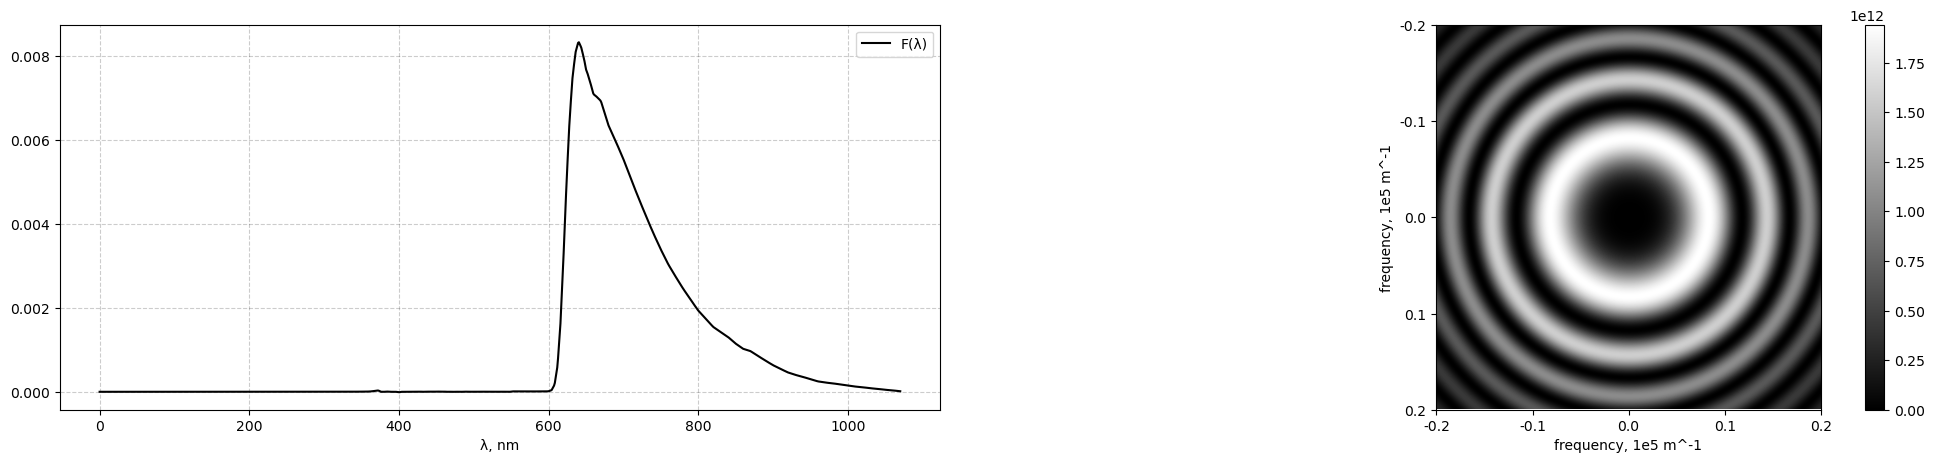

In [7]:
'''
Отрисовка спектрального фильтра и функции отклика для отчета
'''

omega_new = sfilter(z=z)  

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(25, 5))

ax1.plot(resp_f[0], resp_f[1], c='black', label='F(λ)')
ax1.set_xlabel('λ, nm')
ax1.legend()
ax1.grid(color = 'black', linestyle='--', alpha = 0.2)

fig.colorbar(ax3.imshow(omega_new, cmap='gray'), ax=ax3)
ax3.grid(False)
x = np.round(np.linspace(-0.2, 0.2, 5), 2)
ax3.set_xticks(np.linspace(0, omega_new.shape[1], 5))
ax3.set_yticks(np.linspace(0, omega_new.shape[0], 5))
ax3.set_xticklabels(x)
ax3.set_yticklabels(x)
ax3.set_xlabel('frequency, 1e5 m^-1')
ax3.set_ylabel('frequency, 1e5 m^-1')

# fig.savefig('C:/astro/response_func.png', bbox_inches='tight')
print(' ')

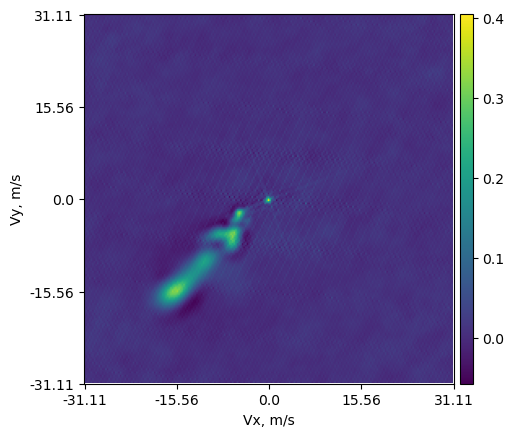

In [8]:
'''
Отрисовка спеклов для отчета
'''

def draw_correlate_with_velocity(data, D, Dpix, latency, sec_per_frame): 
    v = (D / Dpix) / (latency * sec_per_frame)
    x = np.round(v*np.linspace(-data.shape[0]//2+1, data.shape[0]//2, 5), 2)
    y = np.round(v*np.linspace(-data.shape[0]//2+1, data.shape[0]//2, 5), 2)
    y = np.flipud(y)
    fig = plt.figure()
    ax = plt.axes()
    im = plt.imshow(data, cmap = None)
    ax.set_xticks(np.linspace(0, data.shape[1], 5))
    ax.set_yticks(np.linspace(0, data.shape[0], 5))
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)
    ax.set_ylabel('Vy, m/s')
    ax.set_xlabel('Vx, m/s')
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
#     ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
    fig.savefig('C:/astro/cross_corr_m2.png', bbox_inches='tight')

draw_correlate_with_velocity(data_corr, D, frame.shape[0], latency, sec_per_frame)

In [9]:
# мб итоговую гамму обрезать под размер исходног изображения?

# print(threshold_otsu(data_corr))
# plt.imshow(data_corr*(data_corr>(+0.05+threshold_otsu(data_corr))))